In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import random_split
import random
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import torch.nn.init as init
import itertools
import copy
from tqdm import tqdm
import statistics

import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
import io
import sys


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU")

GPU not available. Using CPU


# Load data and split in the multi agent system

First batch of the first agent:
  Images shape: torch.Size([32, 1, 28, 28])
  Labels: tensor([1, 6, 9, 4, 1, 2, 6, 0, 5, 0, 6, 4, 2, 4, 5, 0, 2, 3, 6, 8, 1, 5, 5, 7,
        0, 3, 9, 8, 1, 4, 0, 8])


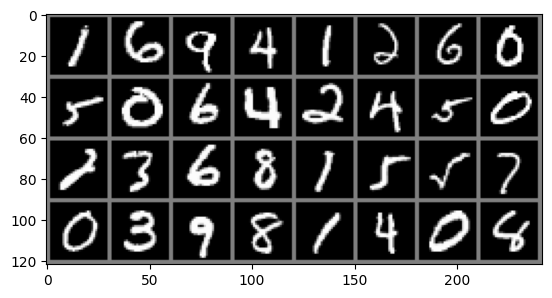

Test loader batch size: 64


In [9]:

def load_mnist(train_subset_size=15000, test_subset_size=1500):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load the full datasets
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Get the subset of indices
    train_indices = np.random.choice(len(train_dataset), train_subset_size, replace=False)
    test_indices = np.random.choice(len(test_dataset), test_subset_size, replace=False)

    # Create subsets
    train_subset = Subset(train_dataset, train_indices)
    test_subset = Subset(test_dataset, test_indices)

    return train_subset, test_subset

# def load_mnist():
#     transform = transforms.Compose(
#         [transforms.ToTensor(),
#          transforms.Normalize((0.5), (0.5))])

#     train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
#                                                  download=True, transform=transform)
#     test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
#                                                 download=True, transform=transform)
#     return train_dataset, test_dataset

def split_dataset_heterogeneously(dataset, num_agents, alpha=.8):
    np.random.seed(42)
    num_samples = len(dataset)
    indices = np.random.permutation(num_samples)
    # Generate Dirichlet distribution for each agent
    proportions = np.random.dirichlet(np.repeat(alpha, num_agents), size=1)[0]
    # Calculate the number of samples for each agent
    agent_sizes = (proportions * num_samples).astype(int)
    # Adjust to ensure all samples are allocated
    agent_sizes[-1] = num_samples - np.sum(agent_sizes[:-1])

    agent_splits = []
    start_idx = 0
    for size in agent_sizes:
        end_idx = start_idx + size
        agent_indices = indices[start_idx:end_idx]
        agent_subset = Subset(dataset, agent_indices.tolist())
        agent_splits.append(agent_subset)
        start_idx = end_idx

    return agent_splits, proportions

def create_dataloaders(train_splits, val_splits, test_set, batch_size=32, test_batch_size=32):
    train_loaders = []
    val_loaders = []
    test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

    for train_data, val_data in zip(train_splits, val_splits):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
        train_loaders.append(train_loader)
        val_loaders.append(val_loader)

    return train_loaders, val_loaders, test_loader

def imshow(img):
    img = img / 2 + 0.5  # unnormalize if necessary
    npimg = img.numpy()

    # Check if the image has 1 channel (grayscale)
    if npimg.shape[0] == 1:
        plt.imshow(npimg[0], cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()

# Parameters
num_agents = 10
batch_size = 32
test_batch_size = 64
#alpha = 0.80 # Dirichlet distribution parameter

# Load and preprocess CIFAR-10 dataset
train_dataset, test_dataset = load_mnist()

# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Split train and validation sets heterogeneously among agents
train_splits, train_proportions = split_dataset_heterogeneously(train_dataset, num_agents)
val_splits, val_proportions = split_dataset_heterogeneously(val_dataset, num_agents)

# Create dataloaders for each agent
train_loaders, val_loaders, test_loader = create_dataloaders(train_splits, val_splits, test_dataset, batch_size, test_batch_size)

# Print and plot the first batch of the first agent
dataiter = iter(train_loaders[0])
images, labels = dataiter.__next__()
print("First batch of the first agent:")
print(f"  Images shape: {images.shape}")
print(f"  Labels: {labels}")

# Plot the images
imshow(torchvision.utils.make_grid(images))
# Verify the size of the test loader
print(f"Test loader batch size: {test_loader.batch_size}")

In [10]:
for i in range(num_agents):
  print(len(train_loaders[i].dataset))

2983
660
1458
509
1316
2132
1828
113
592
409


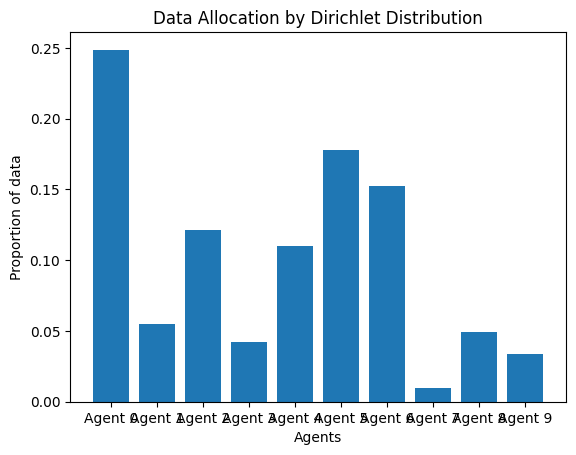

In [11]:
# Plot the proportions
agents = [f'Agent {i}' for i in range(num_agents)]
plt.bar(agents, train_proportions)
plt.xlabel('Agents')
plt.ylabel('Proportion of data')
plt.title('Data Allocation by Dirichlet Distribution')
plt.show()

# Create Graph Topology

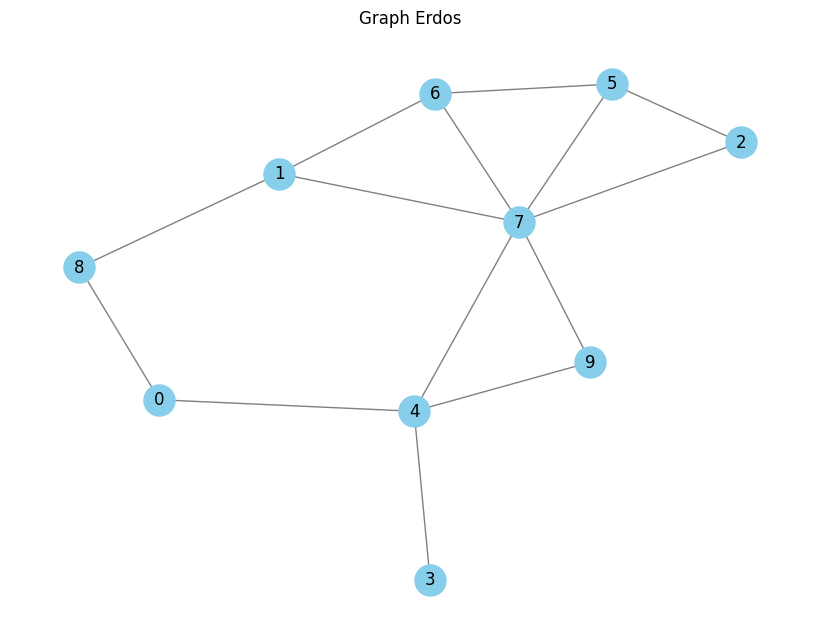

In [157]:
def genera_grafo_connesso(tipo_grafo, num_nodi, prob=None, m=None):
    while True:
        if tipo_grafo == 'erdos':
            if prob is None:
                raise ValueError("Per un grafo di Erdos-Renyi, specificare la probabilità 'prob'")
            G = nx.erdos_renyi_graph(num_nodi, prob)
        elif tipo_grafo == 'scale_free':
            if m is None:
                raise ValueError("Per un grafo scale-free, specificare il numero di archi 'm'")
            G = nx.barabasi_albert_graph(num_nodi, m)
        else:
            raise ValueError("Tipo di grafo non supportato. Scegliere tra 'erdos_renyi' o 'scale_free'")

        # Controlla se il grafo è connesso
        if nx.is_connected(G):
            break

    adj_matrix = nx.adjacency_matrix(G).todense()
    laplacian_matrix = nx.laplacian_matrix(G).todense()

    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
    plt.title(f"Graph {tipo_grafo.replace('_', ' ').title()}")
    plt.show()
    return adj_matrix, laplacian_matrix, G

type_g = 'erdos'
p = 0.25
Adj_matrix, L, G = genera_grafo_connesso(type_g, num_agents, prob=p)
# print("Matrice di adiacenza:\n", A)
# print("Laplaciano:\n", L

# Define learning function at the edge of the network

In [150]:
# class LeNet(nn.Module):
#     def __init__(self, input_channels=1, num_classes=10):
#         super(Net, self).__init__()

#         # Set the seed for reproducibility
#         #torch.manual_seed(0)

#         self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=5)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
#         self.fc1 = nn.Linear(16 * 4 * 4, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, num_classes)

#         # Initialize weights
#         self._initialize_weights()

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2)
#         x = x.view(-1, 16 * 4 * 4)  # Flatten the tensor
#         x = F.relu(self.fc1(x)) #hyperbolic
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#                 init.xavier_normal_(m.weight)
#                 if m.bias is not None:
#                     init.constant_(m.bias, 0)

class Net(nn.Module):
    def __init__(self, input_channels=1, num_classes=10, randomness=False):
        super(Net, self).__init__()
        #torch.manual_seed(0)

        self.conv1 = nn.Conv2d(input_channels, 8, kernel_size=5)
        self.fc1 = nn.Linear(8 * 24 * 24, 32)  # Adjust input size for fully connected layer
        self.fc2 = nn.Linear(32, num_classes)

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = F.gelu(self.conv1(x))  # Using GELU activation function
        x = x.view(-1, 8 * 24 * 24)
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)            # Output layer
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)


# Define Successive Convex Approximation routine:
$$ min_x U(x) = F(x)+G(x) \\
U_i(x) = f_i(\omega_i,x_i) + \sum_{j=1}^I f_j(\omega_i,x_j) + G(x_i) ; i=\{1,..,I\}$$

- The surrogate function for *full linearization* (FL) of the initial possibly non convex cost function is defined as a proximal gradient procedure: $$\tilde{f_i}(x_i|x_i[n])= f_i(x_i[n]) + \nabla f_i(x_i[n])(x_i - x_i[n]) + \frac{\tau}{2}||x_i - x_i[n] ||$$
That solved in closed form produces:
$$\nabla_{x} \tilde{F}(x^k|x_i[n])=0 \\
\nabla_{x}F(x_i[n]) + \tau(x^k-x_i[n])=0 \\
x^{k+1}= x^k - \frac{1}{\tau} \nabla F(x_i[n])$$

- Best Response map aims to approximate for each agent $i^{th}$:
$$ \hat{x_i}(x_i[n]) = argmin_{x_i[n] \in K} \tilde{f_i}(x_i|x_i[n]) + (x_i-x_i[n]) \sum_{j \neq i} ^N \nabla_x f_j(x_i[n]) $$

- Convex smooth combination:
$$ x_i^{k+1} = (1-\gamma^k)x_i + \gamma^k(\hat{x_i}(y^k)) $$

The main idea is to develop a gradient tracking method to implement a fully distributed framework where $\sum_{j \neq i} ^N \nabla_x f_j(x_i[n])$, that is not distributed since anget $i$ need the knowledge of all $j^{}th$ agents gadients; \
Furthermore, the use of dynamic consensus to update the
 objective functions of users' subproblems is a novel idea
 (introduced for the first time in "NEXT-Di Lorenzo & Scutari"), which makes the proposed scheme convergent even in the case of nonconvex
 $F$'s.


## BIO-L-NEXT Algorithm
COMPLETARE E RIVEDERE QUESTO RIASSUNTO DEL METODO

In [158]:
def flatten_param(model, input=None):  # Highlight that you need to pass the
                                       # client class and their model (agents.models) as input!
    flattened_params = []
    if input == None:
      for n,p in model.items():
        flattened_params.append(p.view(-1))
    elif input == "model":
      for param in model.parameters():
        flattened_params.append(param.view(-1))  # Flatten the parameter and add to list

    flattened_vector = torch.cat(flattened_params)  # Concatenate all flattened parameters into a single vector 1D
    return flattened_vector

def get_subset_loader(train_loader, fraction):
    # Convert the DataLoader into a list of batches
    all_batches = list(train_loader)
    # Determine how many batches to use in base of validation accuracy
    num_batches_to_use = int(len(all_batches) * fraction)

    # Randomly select the batches you want to use
    selected_batches = random.sample(all_batches, num_batches_to_use)

    return selected_batches

def get_diffusion(Laplacian):
    eigv, _ = torch.linalg.eig(torch.tensor(Laplacian,  dtype=torch.float32))
    eps = np.random.uniform(0, (2/torch.max(eigv.real).item()))
    #eps = (2/torch.max(eigv.real).item())/100
    #print(f"Learning rate is equal to {round(eps,8)}")
    W = torch.eye(num_agents) - eps * Laplacian
    return W, eps

#Define attraction repulsion function
def g(x, z, pie):
    y = (flatten_param(x))-(flatten_param(z))
    return pie[0]-pie[1]*(-torch.norm(y, p=2)/pie[2])

def reshape_flattened_gradients(flattened_gradients, model):
    reshaped_gradients = {}
    pointer = 0
    for name, param in model.named_parameters():
        param_shape = param.shape
        param_size = param.numel()  # Total number of elements in the parameter tensor
        # Extract the portion of flattened gradients corresponding to this parameter
        reshaped_grad = flattened_gradients[pointer:pointer + param_size].view(param_shape)
       # Store the reshaped gradient in the dictionary
        reshaped_gradients[name] = reshaped_grad.clone().detach()
        # Move the pointer to the next set of gradients
        pointer += param_size
    return reshaped_gradients

# Agents class for federated learning
class Agents:
    def __init__(self, train_loaders, val_loaders, test_loader, num_agents, pie=[], tau = None, epochs=2, gamma_zero = None, iterations = None, symmetry=True, lr=0.01, reg_lambda=.01):
        self.K = iterations
        self.reg_lambda = reg_lambda
        self.pie = pie
        self.train_loaders = train_loaders
        self.val_loaders = val_loaders
        self.test_loader = test_loader
        self.num_agents = num_agents
        self.epochs = epochs
        self.W, self.learning_rate = get_diffusion(L)[0], get_diffusion(L)[1]
        self.gamma_values =[gamma_zero] #gamma[0]< 1/eps
        self.models = [Net().to(device) for _ in range(num_agents)]
        self.optimizers = [optim.SGD(model.parameters(), lr= lr ) for model in self.models]
        self.criterion = nn.CrossEntropyLoss()
        self.validation_accuracies = {i: 1 for i in range(num_agents)}  # Dictionary to store validation accuracies
        self.losses = {i: [] for i in range(num_agents)}  # Dictionary to store losses
        self.previous_response = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ] #store parameters initializations and previous weights iteratively
        self.actual_grads = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        # Initialize Y[0], Z[0], pie_tilde[0] as lists of dictionaries
        self.Y = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        self.pie_tilde = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        self.Z = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        self.next_grads = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        self.stopping_condition = []


    def gamma_update(self, epsilon=0.8): #updating step size rule
        gamma_next = self.gamma_values[-1]*(1-(epsilon*self.gamma_values[-1])) #gamma[0] < 1/eps and eps in (0,1])
        self.gamma_values.append(gamma_next)

    def upd_diffusion(self): #Update non symmetric diffusion matrix
        Upd_w = torch.tensor(list(self.validation_accuracies.values()))*self.W
        M = np.array(Upd_w, dtype=float)
        row_sums = M.sum(axis=1)
        row_sums[row_sums == 0] = 1 #avoid division by zero by setting row sums that are zero to one (this is a really bas case)
        normalized_matrix = M / row_sums[:, np.newaxis]
        #check stochasticity condition
        ones_vector = np.ones(M.shape[0])
        result = np.dot(normalized_matrix, ones_vector)
        if np.allclose(result, ones_vector)== False:
          print("Diffusion matrix do not respect stochasticity conditions")
        self.W = normalized_matrix

    def validate_agent(self, agent_idx):
        model = self.models[agent_idx].to(device)
        val_loader = self.val_loaders[agent_idx]
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            #print(f'Agent {agent_idx} Validation Accuracy: { (correct / total)}')
        self.validation_accuracies[agent_idx]=correct / total


    def plot_losses(self):
      fig, axes = plt.subplots(1, 2, figsize=(12, 6))
      for agent_idx in range(self.num_agents):
          axes[0].plot(self.losses[agent_idx], label=f'Agent {agent_idx}', linestyle='dashdot')
      axes[0].set_xlabel('Epochs')
      axes[0].set_ylabel('Loss')
      axes[0].set_ylim(0, 2.0)#max(self.losses))
      axes[0].set_title('NEXT System Loss behaviour')
      axes[0].legend()

      for k in range(len(self.stopping_condition)):
          axes[1].plot(self.stopping_condition, linestyle='dotted')
      axes[1].set_xlabel('Iteration')
      axes[1].set_ylabel('|| x̂(x[n])-x[n] ||')
      axes[1].set_ylim(0,7.05)# max(self.stopping_condition))
      axes[1].set_title('SCA stopping condition over iterations')

      plt.tight_layout()
      plt.show()

    # def plot_losses(self):
    #     for agent_idx in range(self.num_agents):
    #         plt.plot(self.losses[agent_idx], label=f'Agent {agent_idx}', linestyle='dashdot')
    #     plt.xlabel('Epochs')
    #     plt.ylabel('Loss')
    #     plt.ylim(0,2.5)
    #     #plt.xlim(0,15)
    #     plt.title('NEXT System Loss behaviour')
    #     plt.legend()
    #     plt.show()


    def initialize_agents(self):
        """
        Initialize agents' models and variables.
        """
        wk = Net().to(device).state_dict()

        for i in range(self.num_agents):
            # wk = Net().to(device).state_dict()
            #se inizializzi pe rogni agente una nuova varibaile x[n] ovviamente converge con il coso...come se chiama...
            self.previous_response[i] = wk #store feasible initializations
            #w_previous = self.models[i].state_dict().to(device)
            w_previous = copy.deepcopy(self.models[i].state_dict())
            # Initialize model parameters to wk
            for name, param in self.models[i].named_parameters():
                if name in wk:
                    param.data = wk[name].clone()
            self.models[i].train()
            optimizer = self.optimizers[i]
            #Compute difference among current iterate and previous response variable (x_i - x[n])
            difference = [(w_prev-wk) for (n1,w_prev),(n2,wk) in zip(w_previous.items(), self.models[i].state_dict().items())] #computye and flat difference among w_prev and wk
            difference_flatten = torch.cat([diff.view(-1) for diff in difference])
            all_batch_gradients = []
            for inputs, labels in self.train_loaders[i]:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.models[i](inputs)
                loss = self.criterion(outputs, labels)
                optimizer.zero_grad()
                gradients = torch.autograd.grad(loss, self.models[i].parameters(), retain_graph=True)
                pie_flatten = torch.cat([grad.view(-1) for grad in gradients]).to(device)
                all_batch_gradients.append(pie_flatten.clone().detach())  #initialize y_i[k] as ∇f_i[0]
                # Surrogate loss
                loss_surrogate = loss.clone().detach().requires_grad_(True) + torch.matmul(pie_flatten, difference_flatten)
                loss_surrogate.backward()
                optimizer.step()
            # Update Z
            # for name, param in self.Z[i].items():
            #     self.Z[i][name] += w_previous[name] + ( self.gamma_values[-1] * (w_previous[name] - wk[name]) )
            # Update Y[0]= ∇f_i(w_i[0])
            self.Y[i] = torch.mean(torch.stack(all_batch_gradients), dim=0).to(device) #gradients mean of batches (not of agents!)
            self.pie_tilde[i] = torch.mul(self.Y[i], self.num_agents) - torch.mean(torch.stack(all_batch_gradients), dim=0)
            #self.gamma_update()
#-------------------------------------------------------------------------------
    def run_iterations(self, tolerance = 1e-3, symmetry=True):
        """
        Run K iterations of the NEXT algorithm.
        Step 1: Local Updates leveraging SCA optimization
                Convex smooth with diminishing gamma step size rule
        Step 2: Consensus Step to update model paramters
        Step 3: Local Variables Updates
        """

        diff = {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}

        for k in tqdm(range(self.K),desc= "Processing NEXT training with neighborhood"):
            # Step 1
            stopping_avg = []
            for i in range(self.num_agents):

                optimizer = self.optimizers[i]
                wk = copy.deepcopy(self.models[i].state_dict()) #run this after initialization menas that agent model
                                                                #already have feasible initialization of model parameters
                #print(f"at the beginnin : \n {wk}")
                all_batch_gradients = []
                #Run the surrogate optimization and update parameters with best response map procedure
                #BEST RESPONSE MAP
                #-----------------
                #selected_batches = get_subset_loader(self.train_loaders[i], round(self.validation_accuracies[i],1))
                #print(f"Fraction of data choosed by val_acc is {self.validation_accuracies[i]} for agent {i}")
                #----------------
                running_loss = 0.0
                for inputs, labels in self.train_loaders[i]:
                #for inputs, labels in selected_batches:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self.models[i](inputs)
                    loss = self.criterion(outputs, labels)
                    optimizer.zero_grad()
                    gradients = torch.autograd.grad(loss, self.models[i].parameters(), retain_graph=True)
                    pie_flatten = torch.cat([grad.view(-1) for grad in gradients])
                    all_batch_gradients.append(pie_flatten.clone().detach())
                    # Surrogate loss
                    difference_flatten = flatten_param(self.models[i], input="model") - ( torch.cat([p.view(-1) for n,p in self.previous_response[i].items()])  )
                    #print(difference_flatten)
                    l2_norm = sum(p.pow(2).sum() for p in self.models[i].parameters())
                    loss_surrogate = loss.clone().requires_grad_(True) + torch.matmul(pie_flatten, difference_flatten).requires_grad_(True)#+ (self.reg_lambda*l2_norm) #convex regularizer
                    # print(torch.matmul(pie_flatten, difference_flatten))
                    running_loss += loss_surrogate.item()
                    loss_surrogate.backward()
                    optimizer.step() #best response map update x_hat
                #print(f"After optimiation \n {self.models[i].state_dict()}")

                #Validate agent to break diffusion matrix symmetry
                self.validate_agent(i)
                # Update Z as the convex combination (smooth)
                stopping = 0  # Reset stopping for each agent
                for name, p in self.Z[i].items():
                    self.Z[i][name] = wk[name] +  torch.mul( (self.models[i].state_dict()[name] - wk[name]), self.gamma_values[-1] )
                    stopping += torch.linalg.vector_norm(self.models[i].state_dict()[name] - wk[name])
                stopping_avg.append(stopping)
                #print(f"stopping: {stopping} for agent {i}")

                self.actual_grads[i] = torch.mean(torch.stack(all_batch_gradients), dim=0)
                #store loss function
                avg_loss = running_loss / len(self.train_loaders[i])
                self.losses[i].append(avg_loss)

            stop = sum(stopping_avg) / self.num_agents
            self.stopping_condition.append(stop)
            # Step 2: Consensus Step to update model params
            for i in range(self.num_agents):
                updated_state_dict = {k: torch.zeros_like(p) for k, p in self.models[i].state_dict().items()}
                grads_passing = {k: torch.zeros_like(p) for k, p in self.models[i].state_dict().items()}
                for j in range(self.num_agents):
                  for (name1, w_i), (name2, z_i) in zip(updated_state_dict.items(), self.Z[j].items()):
                    g_bio = g(self.Z[i], self.Z[j], self.pie).type(z_i.dtype)
                    updated_state_dict[name1] +=torch.mul( z_i, g_bio) * self.W[i][j]  # Accumulate contributions from each j with attraction-repulsion function

                # Load updated state dict
                self.models[i].load_state_dict(updated_state_dict)
                self.previous_response[i] = updated_state_dict #load the consensus based update in the previous
                                                               # response variable;
                # Compute next gradients
                all_batch_gradients = []
                for inputs, labels in self.train_loaders[i]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self.models[i](inputs)
                    #l2_norm = sum(p.pow(2).sum() for p in self.models[i].parameters())
                    loss = self.criterion(outputs, labels) #+ l2_norm
                    optimizer = self.optimizers[i]
                    optimizer.zero_grad()
                    loss.backward(retain_graph=True)
                    gradients = torch.autograd.grad(loss, self.models[i].parameters(), retain_graph=True)
                    next_grad_flat = torch.cat([grad.view(-1) for grad in gradients])
                    all_batch_gradients.append(next_grad_flat)
                self.next_grads[i] = torch.mean(torch.stack(all_batch_gradients), dim=0)
                #next_grads.append(torch.mean(torch.stack(all_batch_gradients), dim=0))
                # Update y_i[k+1]
                grads_diff = self.next_grads[i] - self.actual_grads[i]
                grads_diff_resh = reshape_flattened_gradients(grads_diff, self.models[i])

                for j in range(self.num_agents):
                    if j != i:
                      y_j = reshape_flattened_gradients( self.Y[j], self.models[0]  ) #reshape in original paramters nn size
                      for name,p in y_j.items():
                        grads_passing[name] += p*self.W[i][j] #Accumulate contributions from each j^th agent
                for  (n1, consensus),(n2, diff) in zip(grads_passing.items(), grads_diff_resh.items()):
                    grads_passing[n1] = consensus + diff
                self.Y[i] = torch.cat([grad.view(-1) for n,grad in grads_passing.items()])
                # Update pie_tilde
                self.pie_tilde[i] = torch.mul(self.Y[i], self.num_agents ) - self.next_grads[i]

            #print(f"Stop criterion at iteration {k} is equal to {stop}")
            #check convergence
            converged = True
            sum_diff=0
            i_agent = flatten_param(self.models[0], input="model")
            for j_agent in range(self.num_agents):
             if j_agent !=0:
              sum_diff += torch.sum(i_agent - flatten_param(self.models[j_agent], input="model"))
            avg_diff = torch.abs(sum_diff / (self.num_agents) )
            #print(f" \n Average params difference equal to {avg_diff}")
            #if (k + 1) % 20 == 0:
            #print(f"Difference at iteration {k} is equal to {torch.abs(sum_diff)} for agent 0 and {j_agent}")
            if torch.abs(avg_diff) >= tolerance:
              converged = False
            if converged==True:
             print(f" \n Average params difference equal to {avg_diff}")
             print(f"Convergence reached in {k} iterations.")
             break

            # Update gamma and diffusion matrix
            self.gamma_update()
            if symmetry==False:
               self.upd_diffusion()
            #print(self.W)
            #print(f"Validation Accuracies: {self.validation_accuracies}")
            #refresh gradients variables
            self.actual_grads = self.next_grads = [
                {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
                for _ in range(self.num_agents)
            ]
            self.next_grads = [
                {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
                for _ in range(self.num_agents)
            ]


    def NEXT_train(self, symmetry,tolerance=None):
        """
        Execute the full SCA training process.
        """
        self.initialize_agents()
        self.run_iterations(tolerance, symmetry)
        self.plot_losses()


    def test_agent(self, agent_idx):
        model = self.models[agent_idx].to(device)
        test_loader = self.test_loader
        model.eval()

        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        print(f'Agent {agent_idx}  Test Accuracy: {round(test_accuracy * 100, 2)}% ')

        return test_accuracy


In [ ]:
torch.manual_seed(0)

system = Agents(train_loaders, val_loaders, test_loader, num_agents, iterations = 150, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=True, lr=0.1)
system.NEXT_train(tolerance=1e-3, symmetry=True)
system.test_agent(0)


Processing NEXT training with neighborhood:  25%|██▌       | 38/150 [10:42<36:43, 19.68s/it]

In [ ]:
torch.manual_seed(0)
system = Agents(train_loaders, val_loaders, test_loader, num_agents, iterations = 150, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=True, lr=0.1)
system.NEXT_train(tolerance=1e-2, symmetry=False)
system.test_agent(0)

In [ ]:
system.gamma_values

In [ ]:
for idx in range(system.num_agents):
    system.test_agent(idx)

In [ ]:
# pie_1_values = [1.0]
# pie_2_values = np.linspace(0.0, 0.5, 5).tolist()
# pie_3_values = [10]

#torch.manual_seed(0)
# # Use itertools.product to generate all combinations of these values
# pie_grid = list(itertools.product(pie_1_values, pie_2_values, pie_3_values))
# best_acc = 0.0
# best_pie=None

# for pi in pie_grid:
#   print(f"Evaluating params {pi}")
#   system = Agents(train_loaders, val_loaders, test_loader, num_agents, iterations=100, pie=pi)
#   print(f"Learning rate that respect diffusion conensus (W=I-εL) is {system.learning_rate}")
#   stop_iteration = system.NEXT_train(tolerance=1e-2)

#   print("Test accuracy after aggregation process")
#   test_acc = system.test_agent(0)
#   if test_acc>best_acc:
#     best_acc = test_acc
#     best_pie = pi
# print(f"Best pie is {best_pie} with accuracy {best_acc}")

# Codice senza classi

In [ ]:
#NOW NEED TO TEST THE MODEL

In [ ]:
s = Agents(train_loaders, val_loaders, test_loader, num_agents, epochs=2)

# Initializations
wk = Net().state_dict()
pie_tilde =  [{agent:[]} for agent in range(s.num_agents)]
Z = [{agent:[]} for agent in range(s.num_agents)]
Y = [{agent:[]} for agent in range(s.num_agents)]

for i in range(s.num_agents):
    z_k = {k: torch.zeros_like(p) for k, p in wk.items()}
    w_previous = s.models[i].state_dict()

    for name, param in s.models[i].named_parameters(): #Attention load_state_dict() method doesn't works , manually uopdate here
     if name in wk:
        param.data = wk[name].clone()
    s.models[i].train()
    optimizer = s.optimizers[i]
    #Compute difference among current iterate and previous response variable (x_i - x[n])
    difference = [(w_prev-wk) for (n1,w_prev),(n2,wk) in zip(w_previous.items(), s.models[i].state_dict().items())] #computye and flat difference among w_prev and wk
    difference_flatten = torch.cat([diff.view(-1) for diff in difference])
    all_batch_gradients = []
    print(f"AGENT {i}")
    print(s.models[i].state_dict())
    for inputs, labels in s.train_loaders[i]:
        outputs_i = s.models[i](inputs)
        loss_i = s.criterion(outputs_i, labels)  # Surrogate loss for agent i solved in closed form

        optimizer.zero_grad()  # Clear previous gradients
        # Save gradients and flat them in 1D object (we need this to perfom multiplication with difference)
        gradients = torch.autograd.grad(loss_i, s.models[i].parameters(), retain_graph=True)
        # for name, grad in zip(s.models[i].state_dict().keys(), gradients):
        #     y_zero[i][name] += grad.clone().detach()

        pie_flatten = torch.cat([grad.view(-1) for grad in gradients ])
        all_batch_gradients.append(pie_flatten.clone().detach()) #initialize y_i[k] as ∇f_i[0]
        # Add pi_flatten^T * diff_flat to the surrogate loss
        loss_surrogate = loss_i.clone().requires_grad_(True)  + torch.matmul(pie_flatten, difference_flatten).requires_grad_(True)
        loss_surrogate.backward()  # Compute gradients
        optimizer.step()  # Update model parameters
    print("-----------------")
    print(s.models[i].state_dict())
    # Update convex combination z_i[k] variable:
    for n, p in z_k.items():
        z_k[n] += w_previous[n] + 0.5 * (w_previous[n] - wk[n])  # Update rule with gamma
    Z[i]= z_k
    Y[i] = torch.mean(torch.stack(all_batch_gradients), dim=0) #gradients mean of batches (not of agents!)

In [ ]:
Y[0]

tensor([-0.0156, -0.0333, -0.0230,  ..., -0.0034, -0.0289,  0.0065])

In [ ]:
new_state_dict = []
next = []

diff = [{k: torch.zeros_like(p) for k, p in s.models[0].state_dict().items()} for _ in range(s.num_agents)]
for i in range(s.num_agents):
    #Updates of local variables
    # W[k+1]:
    updated_state_dict = {k: torch.zeros_like(p) for k, p in s.models[i].state_dict().items()} #updated weights
    grads_passing = {k: torch.zeros_like(p) for k, p in s.models[i].state_dict().items()} #consensus among diffusion matrix and y_j[k]

    for j in range(s.num_agents):
      for (name1, w_i), (name2, z_i) in zip(updated_state_dict.items(), Z[j].items()):
          g_bio = g(s.Z[i], s.Z[j], [1,.25,10]).type(z_i.dtype)
          updated_state_dict[name1] +=torch.mul( z_i, g_bio) * s.W[i][j]  # Accumulate contributions from each j
      #print(f"Agents: {i,j} with bio coefficient {g_bio}")
    # print(f"Agent {i}")
    # print(updated_state_dict)

    # Load the updated state dictionary back into model i
    # for (n1,upd),(n2,prev) in zip(updated_state_dict.items() , s.models[i].state_dict().items()):
    #   diff[i][n1] += upd - prev

    # new_state_dict.append(updated_state_dict)
    # s.models[i].load_state_dict(updated_state_dict)
    # for inputs, labels in s.train_loaders[i]:
    #     outputs_i = s.models[i](inputs)
    #     loss_nextiter = s.criterion(outputs_i, labels)  # Surrogate loss for agent i solved in closed form

    #     optimizer.zero_grad()  # Clear previous gradients
    #     loss_nextiter.backward(retain_graph=True)  # Compute gradients of iteration [k+1]
    #     # Save gradients
    #     next_gradients = torch.autograd.grad(loss_nextiter, s.models[i].parameters(), retain_graph=True)
    #     next_grad_flat = torch.cat([grad.view(-1) for grad in next_gradients ])
    # next.append(torch.mean(torch.stack(all_batch_gradients), dim=0))
    # #y[k+1]:
    # grads_diff = Y[i] -next_grad_flat[i]
    # grads_diff_resh = reshape_flattened_gradients(grads_diff, s.models[i]) #reshape in orginal parameters size
    # print(grads_diff_resh)
    # for j in range(s.num_agents):
    #     if j != i:
    #       y_k_ = reshape_flattened_gradients(Y[j], s.models[j])
    #       for name, p in y_k_.items():
    #         grads_passing[name] += p * s.W[i][j]  # Accumulate contributions from each j
    # for (n1, grad),(n2, diff) in zip(grads_passing.items(), grads_diff_resh.items()):
    #   grads_passing[n1] = grad + diff
    # Y[i] = torch.cat([grad.view(-1) for n,grad in grads_passing.items() ]) #update y_i[k+1]


    # # pie_tilde[k]:
    # pie_tilde[i] = Y[i] - next[i]


In [ ]:
pie_tilde

[tensor([-0.4466, -0.4068, -0.1043,  ..., -0.1398, -0.4319, -0.2688]),
 tensor([0.6895, 0.6224, 0.5876,  ..., 0.2100, 0.3751, 0.3143]),
 tensor([-0.2062, -0.2847, -0.2279,  ..., -0.0200,  0.1171, -0.2126]),
 tensor([2.0243, 2.0186, 1.8945,  ..., 0.5287, 1.3302, 0.8262]),
 tensor([-0.1963,  0.0836,  0.1435,  ..., -0.1159, -0.0439, -0.0503]),
 tensor([-0.8225, -0.4581, -0.3458,  ..., -0.6218, -0.3131, -0.3138]),
 tensor([-0.0614, -0.0961, -0.1151,  ...,  0.0575, -0.0534, -0.1652]),
 tensor([2.0401, 1.1129, 0.0718,  ..., 0.5995, 0.7635, 0.7039]),
 tensor([ 1.5397,  0.6460,  0.2590,  ...,  0.0363,  0.1882, -0.0502]),
 tensor([-0.0020, -0.0067, -0.0045,  ...,  0.2673, -0.0460, -0.0765])]